In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)

In [2]:
from pathlib import Path, PureWindowsPath
path = PureWindowsPath(os.path.dirname(os.getcwd()) + "\\data\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
# corpus = pd.read_parquet(os.path.dirname(path), engine="fastparquet")
corpus["id"] = list(range(len(corpus)))
corpus = corpus.sort_values("id")
corpus

,id,message,message_preprocessed,category,length
index,,,,,
0,0,Nous avons vu [quoi est Dieu](https://parlafoi.fr/2019/0...,vu quoi dieuhttpsparlafoifrles-cinq-voies- de-thomas-daq...,philosophy,667
1,1,Peut-il faire que les choses passées n’aient pas été ? Non.,peut-il faire chose passée non,philosophy,59
2,2,Peut-il faire les choses qu’il ne fait pas ou omettre ce...,peut-il faire chose fait omettre celles fait oui,philosophy,78
3,3,## Article 1 : Y-a-t-il en Dieu de la puissance ?,article y-a-t-il dieu puissance,philosophy,49
4,4,> On dit dans le psaume 89.9 : « Tu es Puissant Seigneur...,dit psaume « puissant seigneur vérité entoure » thomas a...,philosophy,124
...,...,...,...,...,...
8223,8223,Le baptême ne peut être administré que par un pasteur ou...,baptême peut être administré pasteur a commission dès se...,baptism,832
8224,8224,[![Quand Dieu promet que nos enfants font partie de la N...,quand dieu promet enfant font partie nouvelle allianceht...,baptism,274
8225,8225,## [Quand Dieu promet que nos enfants font partie de la ...,quand dieu promet enfant font partie nouvelle allianceht...,baptism,178


In [3]:
corpus["category"].value_counts()

philosophy    5177
baptism       3051
Name: category, dtype: int64

In [4]:
#Verifier qu'il n'y a pas d'id en doublon
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())

False
False


(0.0, 600.0)

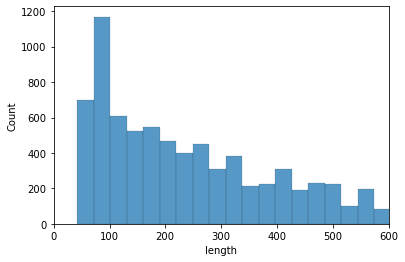

In [5]:
sb.histplot(data=corpus, x="length")
plt.xlim(0, 600)

In [6]:
X = corpus["message_preprocessed"]
y = corpus["category"]

In [7]:
# Methode 1 : CountVectorizer puis TfidfTransformer 
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X)

# transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [8]:
# Methode 2 : TfidfVectorizer (CountVectorizer + TfidfTransformer en meme temps)
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(X)
tfidf_vect.get_feature_names_out()

array(['aaaayaajpgpadqthechildofthecovenantorhowchristianparentsshouldtrainuptheirhouseholds',
       'aaen', 'aaron', ..., 'טבל', 'יהוה', 'ἔθνη'], dtype=object)

In [9]:
#Dimensions de la matrice
print("corpus.shape =", corpus.shape)
print("X_tfidf.shape =", X_tfidf.shape) # = (nb_documents, nb_mots)
print("X_tfidf :")
print(type(X_tfidf))
print(X_tfidf)

corpus.shape = (8228, 5)
X_tfidf.shape = (8228, 12950)
X_tfidf :
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 9310)	0.0676163965363802
  (0, 8220)	0.10405048562122729
  (0, 836)	0.08892541942094587
  (0, 11640)	0.12813829828325518
  (0, 11343)	0.10849318951254834
  (0, 8273)	0.09161069623050055
  (0, 8809)	0.10498916187268116
  (0, 9460)	0.07888594394459283
  (0, 8733)	0.09679056061112536
  (0, 12353)	0.10821343109087218
  (0, 8507)	0.05355489229594013
  (0, 1928)	0.12390604341382504
  (0, 3093)	0.10686603659683235
  (0, 7114)	0.12109510592441985
  (0, 1750)	0.0679871746586059
  (0, 1169)	0.09315796896236794
  (0, 2921)	0.10510938728976266
  (0, 12872)	0.11301323208297374
  (0, 4621)	0.05692426973157179
  (0, 7618)	0.1303222052206023
  (0, 408)	0.0782078905322544
  (0, 9583)	0.12994270247250952
  (0, 12368)	0.11519713902032089
  (0, 12227)	0.1303222052206023
  (0, 10624)	0.1303222052206023
  :	:
  (8226, 3677)	0.20127850055514585
  (8226, 2269)	0.1779810982745558
  (8226, 585)	0.1364367

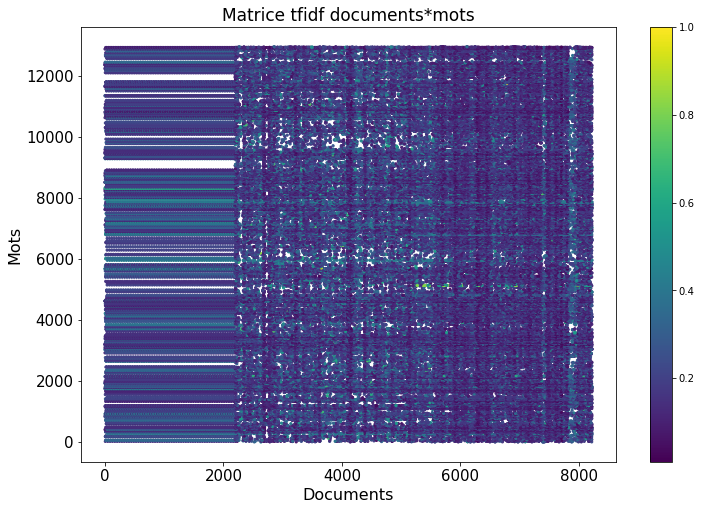

In [18]:
#Plot de la matrice (avec un scatterplot)
X_tfidf_dict = X_tfidf.todok()
X_tfidf_xy = np.array(list(X_tfidf_dict.keys()))
X_tfidf_val = np.array(list(X_tfidf_dict.values()))
plt.scatter(X_tfidf_xy[:,0], X_tfidf_xy[:,1], s=5, c=X_tfidf_val)
plt.xlabel("Documents", size=16)
plt.ylabel("Mots", size=16)
plt.title("Matrice tfidf documents*mots", size=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar()
plt.rcParams["figure.figsize"] = (12, 8)
plt.show()

In [22]:
#Plot de la matrice (avec un scatterplot de seaborn)
X_tfidf_dict = X_tfidf.todok()
# X_tfidf_dict = X_tfidf[:10000,:].todok()
X_tfidf_xy = np.array(list(X_tfidf_dict.keys()))
X_tfidf_val = np.array(list(X_tfidf_dict.values()))

c:\Users\eupho\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


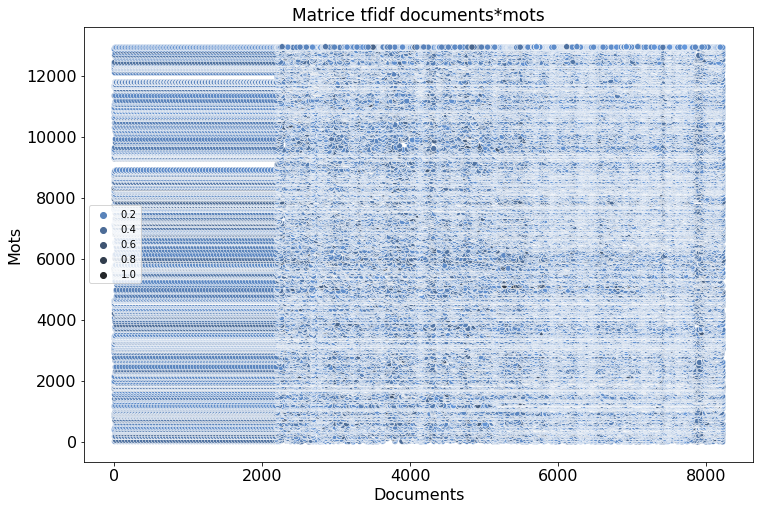

In [30]:
sb.scatterplot(x=X_tfidf_xy[:,0], y=X_tfidf_xy[:,1], hue=X_tfidf_val, palette=sb.dark_palette("#69d", reverse=True, as_cmap=True))
plt.xlabel("Documents", size=16)
plt.ylabel("Mots", size=16)
plt.title("Matrice tfidf documents*mots", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (12, 8)
plt.show()

In [72]:
# Informations sur la matrice #
# Nombre de valeurs non nulles
print("nombre de valeurs non nulles (taille de la matrice csr) =", X_tfidf.count_nonzero())

# Intervalle des valeurs 
print("intervalle des valeurs [{} ; {}]".format(X_tfidf.min(), X_tfidf.max()))

# Valeurs uniques avec unique()
X_tfidf_unique = np.unique(X_tfidf.data)
print("valeurs uniques =", X_tfidf_unique)

# Nombre de valeurs uniques (auquel on additionne 1 pour les 0 qui ne sont pas stockees par definition)
print("nombre de valeurs uniques =", X_tfidf_unique.shape[0] + 1)

nombre de valeurs non nulles (taille de la matrice csr) = 190581
intervalle des valeurs [0.0 ; 1.0]
valeurs uniques = [0.00957734 0.01051434 0.01137626 ... 0.84154412 0.90171148 1.        ]
nombre de valeurs uniques = 99923


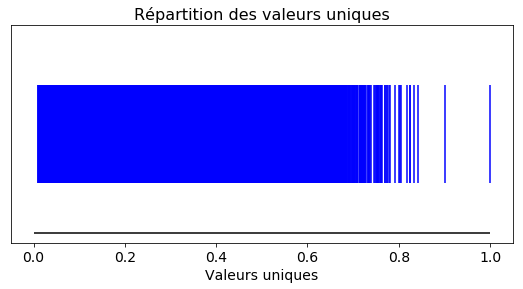

In [108]:
# Graphique avec barres en 1D des valeurs uniques (pour voir comment elles sont reparties, que a droite ?, que a gauche ?, etc.)
# sb.scatterplot(x=X_tfidf_unique, y=np.zeros_like(X_tfidf_unique), sizes=(10000,10000))
plt.figure()
plt.hlines(0,0,1)  # Draw a horizontal line
plt.eventplot(X_tfidf_unique, orientation='horizontal', colors='b')
# plt.axis('off')
plt.xlabel("Valeurs uniques", size=14)
plt.title("Répartition des valeurs uniques", size=16)
plt.xticks(fontsize=14)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.rcParams["figure.figsize"] = (9, 4)
plt.show()

In [ ]:
# Distribution des valeurs non nulles


# Reduction de dimensions pour potentiellement observer des clusters

In [12]:
print("number of dimensions at the beginninig =", X_tfidf.shape)

number of dimensions at the beginninig = (8228, 12950)


TruncatedSVD

In [13]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
svd.fit(X_tfidf)

TruncatedSVD(n_components=50, n_iter=7, random_state=42)

In [14]:
print(svd)

TruncatedSVD(n_components=50, n_iter=7, random_state=42)


In [15]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum() * 100)

print(svd.singular_values_)

[0.02214204 0.02849171 0.01336819 0.01472108 0.01406072 0.01338853
 0.01105526 0.00972424 0.00990406 0.00944134 0.00910863 0.00894204
 0.00857061 0.00832532 0.00776985 0.00756577 0.00754262 0.00751287
 0.00739972 0.00718058 0.00702441 0.00674667 0.00657273 0.00644061
 0.00639934 0.00629671 0.00613635 0.00595706 0.00596562 0.00576104
 0.00563066 0.00552649 0.00550685 0.00535604 0.0051754  0.00505771
 0.0049861  0.00478816 0.00473084 0.00444362 0.00424936 0.00403116
 0.00391589 0.00356406 0.00344005 0.00326585 0.00322066 0.00321214
 0.00312202 0.00285693]
37.55957106819476
[17.82468612 15.313556   11.66360612 10.88488949 10.72223222 10.40073305
  9.50216317  9.12775189  8.9241919   8.73023252  8.62541223  8.49764184
  8.30032523  8.19687033  7.90363218  7.89231656  7.80032948  7.77683294
  7.73149302  7.59755525  7.51597255  7.36439977  7.26880868  7.19567881
  7.17590926  7.11501966  7.02314246  6.93569891  6.92963236  6.80958297
  6.73059188  6.71365692  6.6563395   6.56143246  6.45093

TSNE

In [16]:
X_tfidf.shape
X_tfidf[:100,:]

<100x12950 sparse matrix of type '<class 'numpy.float64'>'
	with 1840 stored elements in Compressed Sparse Row format>

In [27]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, verbose=1)
tsne_results = tsne.fit_transform(X_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8228 samples in 0.003s...
[t-SNE] Computed neighbors for 8228 samples in 14.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8228
[t-SNE] Computed conditional probabilities for sample 2000 / 8228
[t-SNE] Computed conditional probabilities for sample 3000 / 8228
[t-SNE] Computed conditional probabilities for sample 4000 / 8228
[t-SNE] Computed conditional probabilities for sample 5000 / 8228
[t-SNE] Computed conditional probabilities for sample 6000 / 8228
[t-SNE] Computed conditional probabilities for sample 7000 / 8228
[t-SNE] Computed conditional probabilities for sample 8000 / 8228
[t-SNE] Computed conditional probabilities for sample 8228 / 8228
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.818733
[t-SNE] KL divergence after 1000 iterations: 1.629978


In [18]:
type(tsne_results)

numpy.ndarray

In [28]:
corpus["tsne_2d_x"] = tsne_results[:,0]
corpus["tsne_2d_y"] = tsne_results[:,1]
# si trop de donnees
# corpus_extract = corpus.iloc[0:100]
# corpus_extract["tsne_2d_x"] = tsne_results[:,0]
# corpus_extract["tsne_2d_y"] = tsne_results[:,1]
# corpus_extract

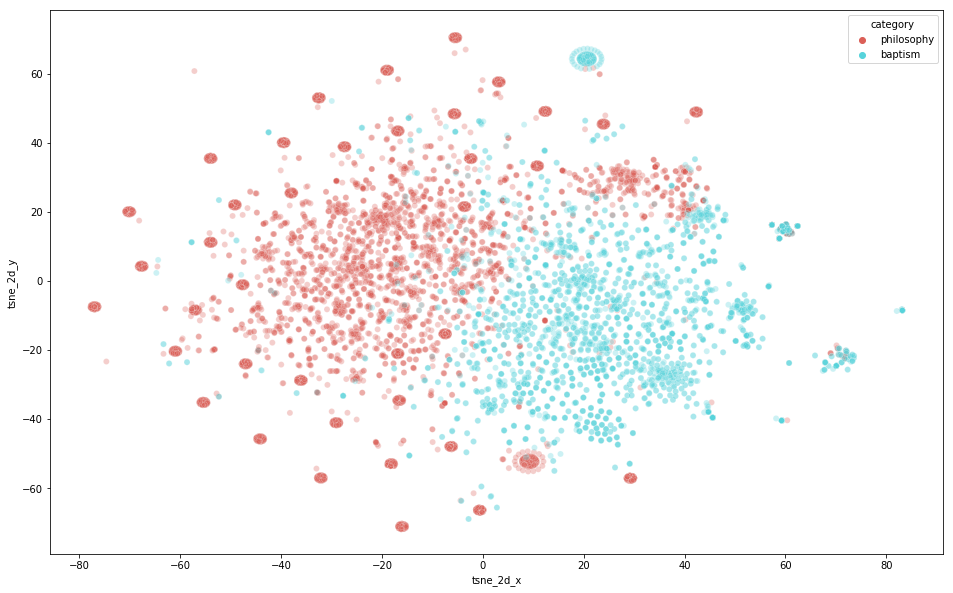

In [30]:
plt.figure(figsize=(16,10))
sb.scatterplot(
    x="tsne_2d_x", y="tsne_2d_y",
    hue="category",
    palette=sb.color_palette("hls", 2),
    data=corpus,
    legend="auto",
    alpha=0.3
)

In [31]:
plt.show()

In [ ]:
X_embedded

In [ ]:
# clustering
# 1. K means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X_tfidf)
